In [1]:
# imports
# You will probably need anaconda to run this code
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
#Put all cleaning steps here

df = pd.read_csv('cfs_data.csv')

df.head()

file_path = 'cfs_data_cleaned'

df['Unit'] = df['Location'].str.extract(r'(?i)((?:apt|bldg)\s+\d+)', expand=False)
df.insert(9,"Unit", df.pop("Unit"))

df['Combined'] = df['Incident Type'].str.contains('combined', case=False, regex=True)
df.insert(8,"Combined", df.pop("Combined"))
df['Incident Type'] = df['Incident Type'].str.replace(r'combined', '', case=False, regex=True).str.strip()

df.to_csv(file_path, index=False)

df.head()

,Date,Time,DOW,CAD Call Number,Case No.,Sectr,RA,Incident Type,Combined,Location,Unit,Common Name,Unit ID,Disposition Comments
0,10/25/2016,10:36,Tuesday,PP16102500000843,NaN,B61,211,WARRANT SERVICE,False,6123 Ruatan St,NaN,NaN,PP/SC166,NaN
1,10/25/2016,13:31,Tuesday,PP16102500001229,NaN,B61,211,UNKNOWN TROUBLE,False,Approx Loc:6215 Greenbelt Rd Eb,NaN,NaN,NaN,NaN
2,10/25/2016,16:12,Tuesday,PP16102500001572,NaN,B61,211,DWI DRIVER,False,Kenilworth Ave Nb / Pontiac St,NaN,NaN,NaN,NaN
3,10/25/2016,16:49,Tuesday,PP16102500001667,NaN,B61,211,HOLD UP ALARM,False,6051 Greenbelt Rd Eb,NaN,CHECKERS - GREENBELT P15311,PP/BH105,378R ACC BY STAFF NO BA
4,10/25/2016,18:06,Tuesday,PP16102500001914,NaN,B61,211,PREMISE CHECK,False,6200 Quebec Pl,NaN,NaN,NaN,300 NF


In [ ]:
# Count each incident type
incident_type_counts = df['Incident Type'].value_counts()

incident_type_counts

,count
Incident Type,
911 DISCONNECT,3355
T - Traffic Stop,1598
UNKNOWN TROUBLE,1174
DISORDERLY,1171
PREMISE CHECK,1136
...,...
TRAINING,1
CHECK OCCUPANCY,1
WIRES DOWN COMBINED,1


In [ ]:
location_counts = df['Location'].value_counts()

location_counts

,count
Location,
6215 Greenbelt Rd Eb,1558
8400 Ballew Ave,1179
8900 Edmonston Rd,594
5815 Greenbelt Rd Eb,575
6219 Greenbelt Rd Eb,519
...,...
8929 57th Ave,1
8509 Paxton Ct,1
8527 58th Ave,1


In [ ]:
common_counts = df['Common Name'].value_counts()


common_counts

,count
Common Name,
MCDONALDS - GREENBELT,497
711 COLLEGE PARK,342
FIRESTATION 2 - SHADY GLEN,175
STAPLES - BERWYN HEIGHTS,164
BERWYN HEIGHTS ELEMENTARY,144
...,...
NATIONAL SPINE AND PAIN CNTR,1
LITTLE CESEARS,1
PARKING SPOT ACROSS STREET,1


In [ ]:
df_encoded = df.copy()
df_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)

categorical_cols = df.columns

le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

X = df_encoded.drop(columns=['Location'])

vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

print(vif_data)

                Variable        VIF
0                   Date   3.931005
1                   Time   5.851335
2                    DOW   3.119371
3        CAD Call Number   6.076093
4               Case No.  26.468974
5                  Sectr  16.701582
6                     RA   2.329707
7          Incident Type   2.867734
8                   Unit  54.282464
9            Common Name  12.050279
10               Unit ID   7.345525
11  Disposition Comments   8.243932


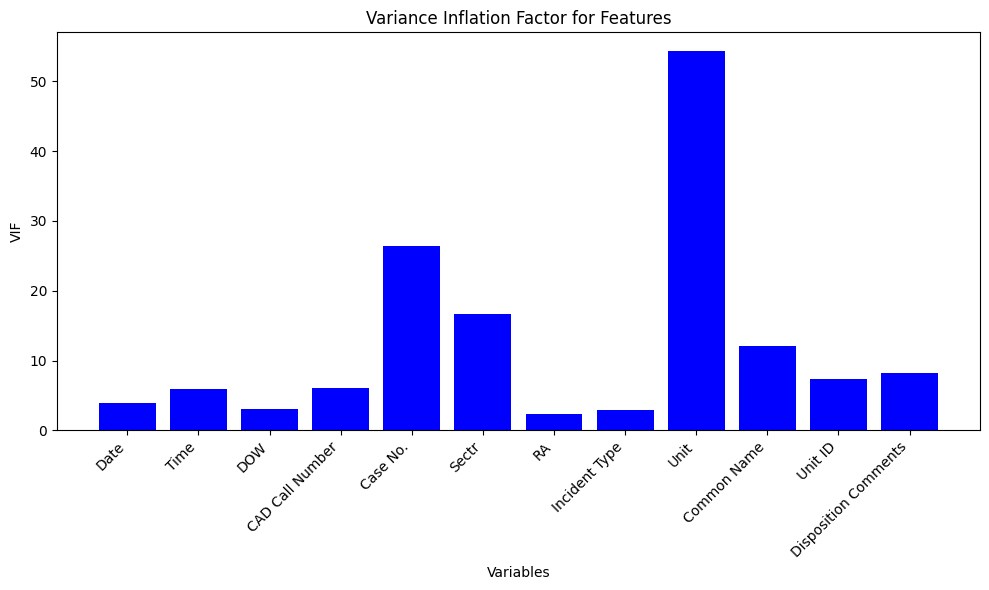

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(vif_data['Variable'], vif_data['VIF'], color='blue')
plt.xlabel('Variables')
plt.ylabel('VIF')
plt.title('Variance Inflation Factor for Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()